

* https://www.kaggle.com/datasets/mrutyunjaybiswal/iitjee-neet-aims-students-questions-data



Donwload Dataset from Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srikresna","key":"c90f9c19af6b129911ae9410dd23cde4"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mrutyunjaybiswal/iitjee-neet-aims-students-questions-data

  0% 0.00/9.60M [00:00<?, ?B/s]
100% 9.60M/9.60M [00:00<00:00, 114MB/s]


In [ ]:
!unzip iitjee-neet-aims-students-questions-data.zip

Archive:  iitjee-neet-aims-students-questions-data.zip
  inflating: subjects-questions.csv  


Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords.words('english')
import string
string.punctuation
from nltk.stem.porter import PorterStemmer
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Understanding Dataset

In [ ]:
df = pd.read_csv('subjects-questions.csv')
df

,eng,Subject
0,An anti-forest measure is\nA. Afforestation\nB...,Biology
1,"Among the following organic acids, the acid pr...",Chemistry
2,If the area of two similar triangles are equal...,Maths
3,"In recent year, there has been a growing\nconc...",Biology
4,Which of the following statement\nregarding tr...,Physics
...,...,...
122514,Which of the following group of\ncharacters is...,Biology
122515,Light year is the\nA. light emitted by the sun...,Physics
122516,Member of Dipnoi are native of\nA. India.\nB. ...,Biology
122517,"In one average-life,\nA. half the active nucle...",Physics


In [ ]:
df.Subject.unique()

array(['Biology', 'Chemistry', 'Maths', 'Physics'], dtype=object)

In [ ]:
df.isna().sum()

eng        0
Subject    0
dtype: int64

Exploratory Data Analysis (EDA)

In [ ]:
df.head()

,eng,Subject
0,An anti-forest measure is\nA. Afforestation\nB...,Biology
1,"Among the following organic acids, the acid pr...",Chemistry
2,If the area of two similar triangles are equal...,Maths
3,"In recent year, there has been a growing\nconc...",Biology
4,Which of the following statement\nregarding tr...,Physics


<Axes: xlabel='count', ylabel='Subject'>

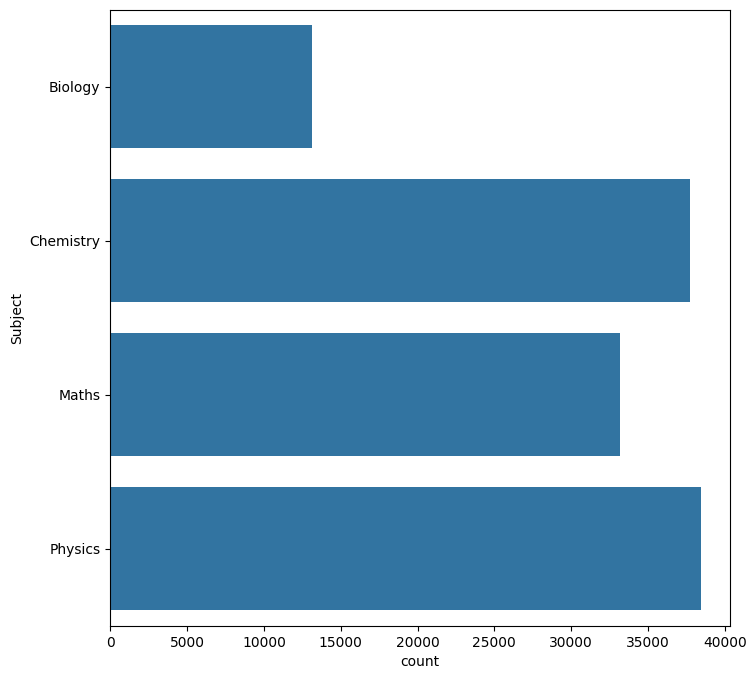

In [ ]:
plt.figure(figsize = (8, 8))
sns.countplot(df['Subject'])

From the countplot above, biology have a less example then another

Data Pre-Processing

because this dataset is categorical, we need doing one-hot encoding first

In [ ]:
category = pd.get_dummies(df.Subject)
df_new = pd.concat([df, category], axis = 1)
df_new = df_new.drop(columns = 'Subject')

df_new

,eng,Biology,Chemistry,Maths,Physics
0,An anti-forest measure is\nA. Afforestation\nB...,1,0,0,0
1,"Among the following organic acids, the acid pr...",0,1,0,0
2,If the area of two similar triangles are equal...,0,0,1,0
3,"In recent year, there has been a growing\nconc...",1,0,0,0
4,Which of the following statement\nregarding tr...,0,0,0,1
...,...,...,...,...,...
122514,Which of the following group of\ncharacters is...,1,0,0,0
122515,Light year is the\nA. light emitted by the sun...,0,0,0,1
122516,Member of Dipnoi are native of\nA. India.\nB. ...,1,0,0,0
122517,"In one average-life,\nA. half the active nucle...",0,0,0,1


Text Processing

Make functions for removal of stopwords, lemmatizing and cleaning text:

In [ ]:
def remove_Stopwords(text ):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize( text.lower() )
    sentence = [w for w in words if not w in stop_words]
    return " ".join(sentence)


def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer()
    sentences=sent_tokenize(text)
    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return ' '.join(wordlist)

def clean_text(text):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    # Remove words starting with \
    text1 = re.sub(r'\\\w*', '', text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr])

    return text2.lower()

def stemSentence(text):
    porter = PorterStemmer()
    token_words=word_tokenize(text)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [ ]:
df_new['new_eng'] = df_new['eng'].apply(clean_text)
df_new['new_eng'] = df_new['new_eng'].apply(remove_Stopwords)
df_new['new_eng'] = df_new['new_eng'].apply(lemmatize_text)
df_new

,eng,Biology,Chemistry,Maths,Physics,new_eng
0,An anti-forest measure is\nA. Afforestation\nB...,1,0,0,0,antiforest measure afforestation b selective g...
1,"Among the following organic acids, the acid pr...",0,1,0,0,among following organic acid acid present ranc...
2,If the area of two similar triangles are equal...,0,0,1,0,area two similar triangle equal equilateral b ...
3,"In recent year, there has been a growing\nconc...",1,0,0,0,recent year growing concern gradually increasi...
4,Which of the following statement\nregarding tr...,0,0,0,1,following statement regarding transformer inco...
...,...,...,...,...,...,...
122514,Which of the following group of\ncharacters is...,1,0,0,0,following group character present chordate sta...
122515,Light year is the\nA. light emitted by the sun...,0,0,0,1,light year light emitted sun one year b time t...
122516,Member of Dipnoi are native of\nA. India.\nB. ...,1,0,0,0,member dipnoi native india b africa australia ...
122517,"In one average-life,\nA. half the active nucle...",0,0,0,1,one averagelife half active nucleus decay b le...


In [ ]:
df_new['stem_eng'] = df_new['new_eng'].apply(stemSentence)

In [ ]:
df_new

,eng,Biology,Chemistry,Maths,Physics,new_eng,stem_eng
0,An anti-forest measure is\nA. Afforestation\nB...,1,0,0,0,antiforest measure afforestation b selective g...,antiforest measur afforest b select graze c cl...
1,"Among the following organic acids, the acid pr...",0,1,0,0,among following organic acid acid present ranc...,among follow organ acid acid present rancid bu...
2,If the area of two similar triangles are equal...,0,0,1,0,area two similar triangle equal equilateral b ...,area two similar triangl equal equilater b iso...
3,"In recent year, there has been a growing\nconc...",1,0,0,0,recent year growing concern gradually increasi...,recent year grow concern gradual increas avera...
4,Which of the following statement\nregarding tr...,0,0,0,1,following statement regarding transformer inco...,follow statement regard transform incorrect tr...
...,...,...,...,...,...,...,...
122514,Which of the following group of\ncharacters is...,1,0,0,0,following group character present chordate sta...,follow group charact present chordat stage lif...
122515,Light year is the\nA. light emitted by the sun...,0,0,0,1,light year light emitted sun one year b time t...,light year light emit sun one year b time take...
122516,Member of Dipnoi are native of\nA. India.\nB. ...,1,0,0,0,member dipnoi native india b africa australia ...,member dipnoi nativ india b africa australia c...
122517,"In one average-life,\nA. half the active nucle...",0,0,0,1,one averagelife half active nucleus decay b le...,one averagelif half activ nucleu decay b le ha...


In [ ]:
df_new.stem_eng[0]

'antiforest measur afforest b select graze c clear forest select fell '

<h1>Model Building

In [ ]:
length = df_new['stem_eng'].str.len().max()
length, df_new.columns

(2658,
 Index(['eng', 'Biology', 'Chemistry', 'Maths', 'Physics', 'new_eng',
        'stem_eng'],
       dtype='object'))

Change into numpy array

In [ ]:
news = df_new['stem_eng'].values
label = df_new[['Biology', 'Chemistry', 'Maths', 'Physics']].values
label, news

(array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        ...,
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1]], dtype=uint8),
 array(['antiforest measur afforest b select graze c clear forest select fell ',
        'among follow organ acid acid present rancid butter pyruv acid b lactic acid c butyr acid acet acid ',
        'area two similar triangl equal equilater b isoscel c congruent congruent ',
        ...,
        'member dipnoi nativ india b africa australia c new zealand none ',
        'one averagelif half activ nucleu decay b le half activ nucleu decay c half activ nucleu decay nucleu decay ',
        'state whether true fals magnet field region around magnet magnet line forc act true b fals '],
       dtype=object))

Divided into training and test

In [ ]:
news_train, news_test, label_train, label_test = train_test_split(news, label, test_size = 0.2, random_state = 123)

Tokenizer dataset

The `maxlen` parameter in `pad_sequences` determines the maximum length of all sequences. If a sequence is shorter than the specified `maxlen`, it will be padded with zeros at the end (or at the beginning if you specify `padding='pre'`). If a sequence is longer than `maxlen`, it will be truncated.

Choosing the right `maxlen` depends on your data and the problem you're trying to solve. Here are some strategies you can use:

1. **Maximum length of sequences in your data**: You can set `maxlen` to be the length of the longest sequence in your data. This ensures that you're not losing any information from truncation. However, this could result in a lot of padding for shorter sequences.

    ```python
    maxlen = max(len(sequence) for sequence in sequences_train)
    ```

2. **Average length of sequences in your data**: You can set `maxlen` to be the average length of sequences in your data. This could be a good balance between information loss from truncation and excessive padding.

    ```python
    maxlen = int(sum(len(sequence) for sequence in sequences_train) / len(sequences_train))
    ```

3. **Percentile of sequence lengths**: You can set `maxlen` to be a high percentile of the sequence lengths in your data. For example, the 90th percentile length would be a length such that 90% of sequences are shorter than it. This allows you to keep most of the information while avoiding excessive padding for very long sequences.

    ```python
    maxlen = int(np.percentile([len(sequence) for sequence in sequences_train], 90))
    ```

Remember, the choice of `maxlen` could significantly impact your model's performance, so it's a good idea to experiment with different values and see what works best for your specific problem.

In [ ]:
tokenizer = Tokenizer(num_words = length, oov_token = '<OOV>')
tokenizer.fit_on_texts(news_train)
tokenizer.fit_on_texts(news_test)

sequences_train = tokenizer.texts_to_sequences(news_train)
sequences_test = tokenizer.texts_to_sequences(news_test)

In [ ]:
# maxlen = max(len(sequence) for sequence in sequences_train)
maxlen = int(sum(len(sequence) for sequence in sequences_train) / len(sequences_train))
# maxlen = int(np.percentile([len(sequence) for sequence in sequences_train], 90))
maxlen

21

In [ ]:
padded_train = pad_sequences(sequences_train,
                             maxlen = maxlen,
                             padding = 'post',
                             truncating = 'post')
padded_test = pad_sequences(sequences_test,
                            maxlen = maxlen,
                            padding = 'post',
                            truncating = 'post')

padded_train

array([[2630, 1398,  291, ...,    4,    1,   13],
       [   1,   46,  525, ...,    0,    0,    0],
       [ 246,  575,    1, ...,  575,  599,    4],
       ...,
       [ 711,  143,  176, ...,    0,    0,    0],
       [   1,  956,  806, ...,    0,    0,    0],
       [2109,   36,    5, ..., 1013,  286,  113]], dtype=int32)

use sequential model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=256, input_length=maxlen),
    tf.keras.layers.LSTM(512),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(254, activation='relu'),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
#compile

model.compile(loss ='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
#cek model

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 21, 256)           2560000   
                                                                 
 lstm_1 (LSTM)               (None, 512)               1574912   
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 254)               130302    
                                                                 
 dense_6 (Dense)             (None, 128)               32640     
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 4,561,026
Trainable params: 4,561,026
No

In [ ]:
#Callback Function
class accCallback(Callback):
   def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.98 and logs.get('val_accuracy') >= 0.98):
            print("\nAccuracy and Val_Accuracy has reached 98%!", "\nEpoch: ", epoch)
            self.model.stop_training = True

callbacks = accCallback()

auto_reduction_LR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 2, #setelah 2 epoch, jika tidak ada kenaikan maka LR berkurang
    verbose = 1,
    factor = 0.2,
    min_lr = 0.000003
)

auto_stop_learn = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = 'auto'
)

#latih model
history = model.fit(padded_train, label_train,
                    epochs = 100,
                    batch_size=128,
                    steps_per_epoch = 30,
                    validation_data = (padded_test, label_test),
                    verbose = 1,
                    callbacks=[callbacks, auto_reduction_LR, auto_stop_learn],
                    )

Epoch 1/100
30/30 [==============================] - 131s 4s/step - loss: 1.0504 - accuracy: 0.5307 - val_loss: 0.6431 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 2/100
30/30 [==============================] - 102s 3s/step - loss: 0.5057 - accuracy: 0.8124 - val_loss: 0.4406 - val_accuracy: 0.8408 - lr: 0.0010
Epoch 3/100
30/30 [==============================] - 110s 4s/step - loss: 0.3766 - accuracy: 0.8646 - val_loss: 0.3458 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 4/100
30/30 [==============================] - 112s 4s/step - loss: 0.3236 - accuracy: 0.8859 - val_loss: 0.3123 - val_accuracy: 0.8885 - lr: 0.0010
Epoch 5/100
30/30 [==============================] - 114s 4s/step - loss: 0.3065 - accuracy: 0.8928 - val_loss: 0.2893 - val_accuracy: 0.8994 - lr: 0.0010
Epoch 6/100
30/30 [==============================] - 106s 4s/step - loss: 0.2836 - accuracy: 0.9005 - val_loss: 0.2854 - val_accuracy: 0.9010 - lr: 0.0010
Epoch 7/100
30/30 [==============================] - 108s 4s/step - lo

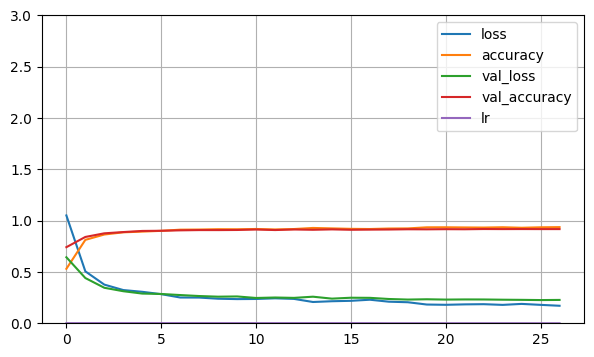

In [ ]:
  #plotting

pd.DataFrame(history.history).plot(figsize=(7, 4))
plt.grid(True)
plt.gca().set_ylim(0,3) #sumbu y

plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(padded_train, label_train)

Counter(np.argmax(y_res, axis = 1))

Counter({2: 30662, 1: 30662, 3: 30662, 0: 30662})

In [46]:
#compile

model.compile(loss ='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [47]:
new_history = model.fit(X_res, y_res,
                         batch_size = 128,
                    steps_per_epoch = 30,
                    epochs = 100,
                    validation_data = (padded_test, label_test),
                    verbose = 1,
                    callbacks=[callbacks, auto_reduction_LR, auto_stop_learn],
                    )

Epoch 1/100
30/30 [==============================] - 69s 2s/step - loss: 0.4532 - accuracy: 0.8352 - val_loss: 0.3448 - val_accuracy: 0.8891 - lr: 0.0010
Epoch 2/100
30/30 [==============================] - 64s 2s/step - loss: 0.4589 - accuracy: 0.8393 - val_loss: 0.3475 - val_accuracy: 0.8825 - lr: 0.0010
Epoch 3/100
30/30 [==============================] - ETA: 0s - loss: 0.4353 - accuracy: 0.8484
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
30/30 [==============================] - 62s 2s/step - loss: 0.4353 - accuracy: 0.8484 - val_loss: 0.3623 - val_accuracy: 0.8662 - lr: 0.0010
Epoch 4/100
30/30 [==============================] - 63s 2s/step - loss: 0.4190 - accuracy: 0.8516 - val_loss: 0.3200 - val_accuracy: 0.8815 - lr: 2.0000e-04
Epoch 5/100
30/30 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.8497
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
30/30 [==============================] - 103s 4s

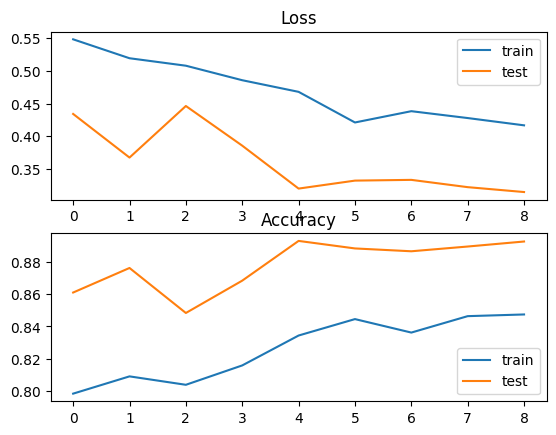

In [45]:
# plot loss
plt.subplot(211)
plt.title('Loss')
plt.plot(new_history.history['loss'], label='train')
plt.plot(new_history.history['val_loss'], label='test')
plt.legend()

# plot accuracy
plt.subplot(212)
plt.title('Accuracy')
plt.plot(new_history.history['accuracy'], label='train')
plt.plot(new_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


In [ ]:
# sanity check
sentence = ["antiforest measur afforest b select graze c clear forest select fell"]
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=10, padding='post', truncating='post')
pred = model.predict(padded)
pred

In [ ]:
# Get the index of the class with the highest predicted probability
predicted_class = np.argmax(pred)

# Print the predicted class
print(f"The model predicts that the sentence is in class {predicted_class}")

In [ ]:
# sanity check actual vs prediction
y_pred = model.predict(padded_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(label_test, axis = 1)

class_names = ['Biology', 'Chemistry', 'Maths', 'Physics']
actual = [class_names[i] for i in y_test]
prediction = [class_names[i] for i in y_pred]

# # data frame actual vs prediction include text
df_pred = pd.DataFrame({'actual': actual, 'prediction': prediction, 'text': news_test})
df_pred